# Fetal immune atlas - BBKNN Integration

In this notebook we perform integration of datasets from different organs

In [64]:
import os,sys
import numpy as np 
import pandas as pd
import scanpy as sc
import scanpy.external as sce
import anndata
from bbknn import bbknn
import scipy

## For geosketch integration
from geosketch import gs, uniform, srs, kmeanspp
from scanorama import transform
from scipy.sparse import csr_matrix, find
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize
# from subprocess import Popen
# import sys
from time import time
from datetime import datetime

### Load merged dataset 

In [2]:
merged_raw = sc.read_h5ad('/nfs/team205/ed6/data/Fetal_immune/PAN.A01.v01.entire_data_normalised_log.wGut.h5ad')

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [17]:
merged_raw.obs['batch'] = [x+y for x,y in zip(merged_raw.obs['organ'],merged_raw.obs['method'])]
merged_raw.obs['bbk'] = [x+y for x,y in zip(merged_raw.obs['donor'],merged_raw.obs['method'])]

Change barcodes for gut cells

In [2]:
def _rename_gut_cells(x):
    if "FCA" not in x:
        x = x.split("_")[8].split('-')[1] + "-1"  + "_" + "_".join(x.split("_")[3:6])
    else: 
        x = x.split("_")[7].split('-')[1] + "-1" + "_" + "_".join(x.split("_")[3:5]) 
    return(x)

In [23]:
obs_names[gut_ixs]

array(['AAACCTGAGACCCACC-1_Human_colon_16S7985393',
       'AAACCTGAGGCAGGTT-1_Human_colon_16S7985393',
       'AAACCTGAGTAGGTGC-1_Human_colon_16S7985393', ...,
       'TTTGTCAGTCCTCTTG-1_Human_colon_16S7985391',
       'TTTGTCAGTTTCGCTC-1_Human_colon_16S7985391',
       'TTTGTCATCTCCAGGG-1_Human_colon_16S7985391'], dtype=object)

In [ ]:
obs_names = merged_raw.obs_names.values
gut_ixs = np.where(merged_raw.obs.organ=="GU")[0]
for i in gut_ixs:
    obs_names[i] = _rename_gut_cells(obs_names[i])

In [6]:
merged_raw.obs_names = obs_names

### Add obs with uniform labels and correct metadata

Made uniform in `notebooks/20210112_saveLabels.ipynb`

In [65]:
new_obs = pd.read_csv("/nfs/team205/ed6/data/Fetal_immune/PAN.A01.v01.entire_data_normalised_log.wGut.full_obs.csv")

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (10,17,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [66]:
merged_raw.obs = new_obs

NameError: name 'merged_raw' is not defined

### Dataset subsetting with Geometric sketching 
To speed up the integration from a large number of cells we will use the geometric sketching approach introduced by [Hie et al.(2019)](https://www.cell.com/cell-systems/fulltext/S2405-4712(19)30152-8). Briefly, this is a strategy to subset a large single-cell dataset by sampling not uniformly across the whole dataset, but sampling in a _plaid covering_ of the dataset, which approximates the geometry of the given single-cell data as a union of equal-sized boxes. As dimensions for plaid covering we use diffusion components and PCs.

In [4]:
## Load cell cycle genes
cwd = '/nfs/team205/ed6/data/Fetal_immune/Pan_fetal/JP_archive/18_Pan_fetal/scjp'
sys.path.append(cwd)

In [6]:
from scjp.genes import cc_genes

In [7]:

def remove_geneset(adata,geneset):
    adata = adata[:,~adata.var_names.isin(list(geneset))].copy()
    return adata

def get_subset(idata, select, cc_genes=cc_genes, log=False,raw=True):
    if raw:
        adata = sc.AnnData(idata[select].raw.X)
        adata.var = idata.raw.var
    else:
        adata = sc.AnnData(idata[select].X)
        adata.var = idata.var
    adata.obs = idata.obs[select]
    adata.raw = adata.copy()
    #adata.X = scipy.sparse.csr_matrix(np.exp(adata.X.todense())-1)
    sc.pp.filter_genes_dispersion(adata,log=log)
    if log:
        sc.pp.log1p(adata)
    sc.pp.scale(adata,max_value=10)
    if len(cc_genes)>0:
        print('removing cc_genes...')
        adata = remove_geneset(adata,cc_genes)
    sc.pp.pca(adata,n_comps = np.min([50,adata.X.shape[0],adata.X.shape[1]]))
    return adata

def is_cycling(adata,cc_genes=cc_genes,cut_off=0.4):
    X = np.mean(adata.X[:,adata.var_names.isin(cc_genes)],axis=1)
    plt.hist(X)
    adata.obs['Cycle_score'] = X
    adata.obs['isCycle'] = X>cut_off

def preprocess4sketch(sdata, how="pd"):
    sc.pp.filter_genes_dispersion(sdata)
    sc.pp.scale(sdata,max_value=10)
    sdata = remove_geneset(sdata,cc_genes)
    if "p" in how:
        sc.pp.pca(sdata)
    if "d" in how:
        sc.pp.neighbors(sdata)
        sc.tl.diffmap(sdata)
    return sdata

def get_sketch_single(sdata,folds=10,how='pd',min_num_per_key=500):
    '''
    geometric sketching based on diffusion map and pca
    - folds: folds to subsample
    - min_num_per_key: minimun number to sample
    '''
    c = sdata.shape[0]
    print('from:',c)

    N = np.max([np.int(c/folds),np.min([min_num_per_key,c])])
    print('to select:',N)
    if how =='pd':
        set1 = set(sdata.obs_names[gs(sdata.obsm['X_diffmap'],N,replace=False)])
        set2 = set(sdata.obs_names[gs(sdata.obsm['X_pca'][:,:50],N,replace=False)])
        sketch_index = list(set1.union(set2))
    elif how =='p':
        set2 = set(sdata.obs_names[gs(sdata.obsm['X_pca'][:,:50],N,replace=False)])
        sketch_index = list(set2)
    elif how =='d':
        set1 = set(sdata.obs_names[gs(sdata.obsm['X_diffmap'][:,:20],N,replace=False)])
        sketch_index = list(set1)
    else:
        raise SystemError
    print('length of sketch:',len(sketch_index))
    return(sketch_index)

In [33]:
## Split by dataset (batch column)
datasets_adatas = []
for i in merged_raw.obs["batch"].unique():
    datasets_adatas.append(merged_raw[merged_raw.obs["batch"]==i])

## Basic preprocessing (each batch separately)
for i in range(len(datasets_adatas)):
    datasets_adatas[i] = preprocess4sketch(datasets_adatas[i])

# Get sketch for each dataset
sketch_idxs = [
    get_sketch_single(X, folds=10, min_num_per_key=500)
    for X in datasets_adatas
]

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
Trying to set attribute `.var` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/numba/core/typed_passes.py:314: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../home/jovyan/.local/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def eu

from: 152341
to select: 15234
length of sketch: 26917
from: 51171
to select: 5117
length of sketch: 8921
from: 40621
to select: 4062
length of sketch: 7175
from: 54925
to select: 5492
length of sketch: 9444
from: 17799
to select: 1779
length of sketch: 3113
from: 75592
to select: 7559
length of sketch: 13013
from: 68571
to select: 6857
length of sketch: 12061
from: 85718
to select: 8571
length of sketch: 15215
from: 54664
to select: 5466
length of sketch: 9732
from: 61666
to select: 6166
length of sketch: 10796
from: 4926
to select: 500
length of sketch: 864
from: 22999
to select: 2299
length of sketch: 4041
from: 112963
to select: 11296
length of sketch: 19677
from: 4356
to select: 500
length of sketch: 878
from: 41230
to select: 4123
length of sketch: 6855
from: 64253
to select: 6425
length of sketch: 11268


In [34]:
sketch_idxs_all = np.concatenate([ X[idx].obs_names for X, idx in zip(datasets_adatas, sketch_idxs)])
sketch_adata = merged_raw[sketch_idxs_all].copy()

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [35]:
sketch_adata.write_h5ad('/nfs/team205/ed6/data/Fetal_immune/PAN.A01.v01.entire_data_normalised_log.wGut.sketch.h5ad')

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'uniform_label' as categorical
... storing 'batch' as categorical
... storing 'bbk' as categorical


In [10]:
sketch_adata = sc.read_h5ad('/nfs/team205/ed6/data/Fetal_immune/PAN.A01.v01.entire_data_normalised_log.wGut.sketch.h5ad')

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Ridge regression of nuisance variables on sketch

In [29]:
# batch regression methods

def regress_batch_v2(adata,batch_key,confounder_key):
    '''batch regression tool
    batch_key=list of observation categories to be regressed out
    confounder_key=list of observation categories to be kept
    returns ndata with corrected X'''

    from sklearn.linear_model import Ridge
    
    print('fitting linear model...')
    dummy = pd.get_dummies(adata.obs[batch_key+confounder_key],drop_first=False)
    X_exp = adata.X # scaled data
    if scipy.sparse.issparse(X_exp):
        X_exp = X_exp.todense()
    LR = Ridge(fit_intercept=False,alpha=1.0,solver="lsqr")
    LR.fit(dummy,X_exp)

    if len(batch_key)>1:
        batch_index = np.logical_or.reduce(np.vstack([dummy.columns.str.startswith(x) for x in batch_key]))
    else:
        batch_index = np.vstack([dummy.columns.str.startswith(x) for x in batch_key])[0]
    
    print('correcting batch...')
    dm = np.array(dummy)[:,batch_index]
    X_explained = dm.dot(LR.coef_[:,batch_index].T)
    X_remain = X_exp - X_explained
    ndata = sc.AnnData(X_remain)
    ndata.obs = adata.obs
    ndata.var = adata.var
    return ndata, X_explained

def ridge_regression_v3(adata,batch_key,confounder_key=[], chunksize=1e8):
    '''
    batch regression tool
    batch_key=list of observation categories to be regressed out
    confounder_key=list of observation categories to be kept
    chunksize=how many elements of X to process at once, will iterate over genes
    corrects X in the adata and adds .uns['X_explained']
    '''
    
    from sklearn.linear_model import Ridge
    
    dummy = pd.get_dummies(adata.obs[batch_key+confounder_key],drop_first=False)
    if len(batch_key)>1:
        batch_index = np.logical_or.reduce(np.vstack([dummy.columns.str.startswith(x) for x in batch_key]))
    else:
        batch_index = np.vstack([dummy.columns.str.startswith(x) for x in batch_key])[0]
    dm = np.array(dummy)[:,batch_index]
    
    chunkcount = np.ceil(chunksize/adata.shape[1])
    X_explained = []
    X_remain = []
    n=1
    indxs = np.arange(0,adata.shape[1],chunkcount).astype('int')
    for ind in indxs:
        print("Fitting chunk {n}/{tot_chunks}".format(n = n, tot_chunks = len(indxs)))
        X_exp = adata.X[:,ind:(ind+chunksize)] # scaled data
        if scipy.sparse.issparse(X_exp):
            X_exp = X_exp.todense()
        print("starting fit...")
        LR = Ridge(fit_intercept=False,alpha=1.0)
        LR.fit(dummy,X_exp)    
        print("finishing fit...")
        X_explained.append(dm.dot(LR.coef_[:,batch_index].T))
        X_remain.append(X_exp - X_explained[-1])
        print("NExt!")
        n+=1
    
    X_explained = np.hstack(X_explained)
    X_remain = np.hstack(X_remain)
    
    adata.X = X_remain
    adata.uns['X_explained'] = X_explained

In [24]:
X_explained

NameError: name 'X_explained' is not defined

In [11]:
sketch_adata = preprocess4sketch(sketch_adata, how="p")

In [23]:
start=datetime.now()
ndata2, X_explained2 = ridge_regression_v3(sketch_adata, batch_key=['method','donor'],confounder_key=['uniform_label'],
                                          chunksize = 50000)
v3_time = datetime.now()-start
print("Ridge V2 runtime: ", str(v3_time))

Fitting chunk 1/201
starting fit...
finishing fit...
NExt!
Fitting chunk 2/201
starting fit...
finishing fit...


KeyboardInterrupt: 

In [25]:
start=datetime.now()
ndata, X_explained = regress_batch_v2(sketch_adata, batch_key=['method','donor'],confounder_key=['uniform_label'])
v2_time = datetime.now()-start
print("Ridge V2 runtime: ", str(v2_time))

fitting linear model...
correcting batch...
Ridge V2 runtime:  0:14:19.050515


In [27]:
start=datetime.now()
ndata, X_explained = regress_batch_v2(sketch_adata, batch_key=['method','donor'],confounder_key=['uniform_label'])
v2_time = datetime.now()-start
print("Ridge V2 runtime: ", str(v2_time))

fitting linear model...
correcting batch...
Ridge V2 runtime:  0:00:29.746676


In [45]:
ndata, X_explained = regress_batch_v2(sketch_adata, batch_key=['method','donor'],confounder_key=['uniform_label'])
sc.pp.pca(ndata)

fitting linear model...
correcting batch...


#### Check that integration on sketch looks reasonable

In [46]:
bbknn(ndata, batch_key = "bbk", n_pcs=30, approx=True)
sc.tl.umap(ndata)

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/bbknn/__init__.py:289: FutureWarning: This location for 'distances' is deprecated. It has been moved to .obsp[distances], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['distances'] = bbknn_out[0]
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/bbknn/__init__.py:290: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'] = bbknn_out[1]


/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


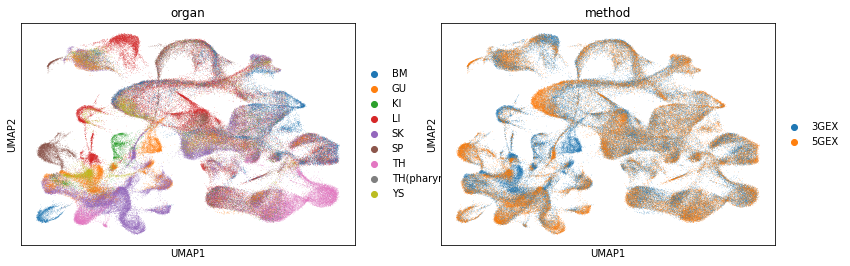

In [47]:
sc.pl.umap(ndata, color=["organ", "method"])

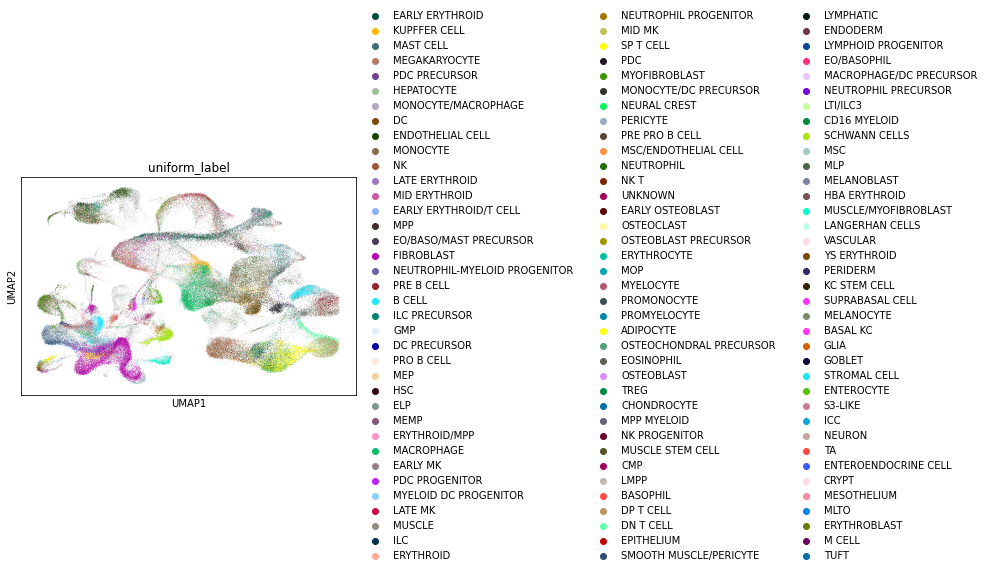

In [49]:
sc.pl.umap(ndata, color="uniform_label", palette=sc.plotting.palettes.default_102,
          groups=ndata.obs[~(ndata.obs["uniform_label"] == 'nan')].uniform_label.unique())

In [50]:
ndata.write_h5ad('/nfs/team205/ed6/data/Fetal_immune/PAN.A01.v01.entire_data_normalised_log.wGut.sketch.batchCorrected.h5ad')

In [52]:
## Free up some memory
del datasets_adatas

In [56]:
import gc
gc.collect()

65918

### Projection of full dataset on batch corrected reduced dimensions 

Code adapted from [`geosketch/bin/integration.py`](https://github.com/brianhie/geosketch/blob/master/bin/integration.py)

In [58]:
## Preprocess full dataset
merged_pp = preprocess4sketch(merged_raw, how="p")

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [130]:
merged_pp.write_h5ad('/nfs/team205/ed6/data/Fetal_immune/PAN.A01.v01.entire_data_normalised_log.wGut.preprocessed.h5ad')

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  for key in string_cols:


In [28]:
merged_pp = sc.read_h5ad('/nfs/team205/ed6/data/Fetal_immune/PAN.A01.v01.entire_data_normalised_log.wGut.preprocessed.h5ad')

In [30]:
start=datetime.now()
ndata, X_explained = regress_batch_v2(merged_pp, batch_key=['method','donor'],confounder_key=['uniform_label'])
v2_time = datetime.now()-start
print("Ridge V2 runtime: ", str(v2_time))

fitting linear model...
correcting batch...
Ridge V2 runtime:  1:20:08.184789


In [31]:
sc.pp.pca(ndata)

In [ ]:
### Projecting full dataset on sketch ###
# ## Extract dim reduction matrices
# X_int = ndata.obsm["X_pca"]
# X_dimred = merged_pp.obsm["X_pca"]
# X_dimred_sketch = merged_pp[ndata.obs_names].obsm["X_pca"]

# ## Find nearest neighbors to sketch cells in full dataset
# neigh = NearestNeighbors(n_neighbors=60).fit(X_dimred)
# _, neigh_idx = neigh.kneighbors(X_dimred_sketch)

# ds_idxs, ref_idxs = [], []
# for ref_idx in range(neigh_idx.shape[0]):
#     for k_idx in range(neigh_idx.shape[1]):
#         ds_idxs.append(neigh_idx[ref_idx, k_idx])
#         ref_idxs.append(ref_idx)

# ## Interpolation
# bias = transform(X_dimred, X_int, ds_idxs, ref_idxs, 15, batch_size=5000)
# dataset_int = X_dimred + bias

# merged_pp.obsm["X_pca"] = dataset_int ## I have to name it like this to use with BBKNN
# merged_pp.obsm["X_pca_old"] = X_dimred

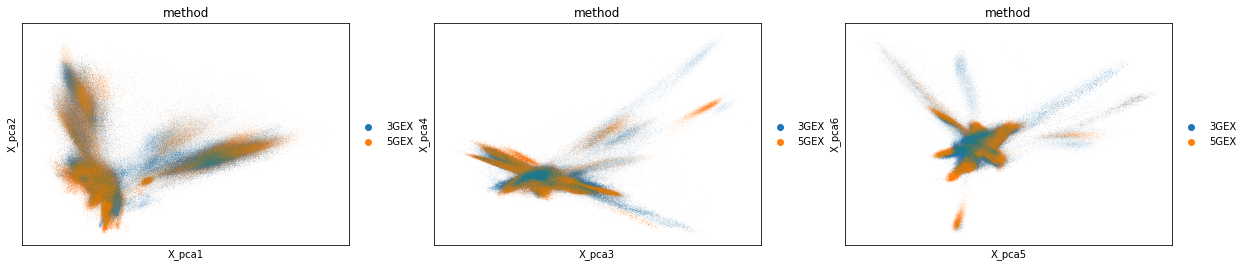

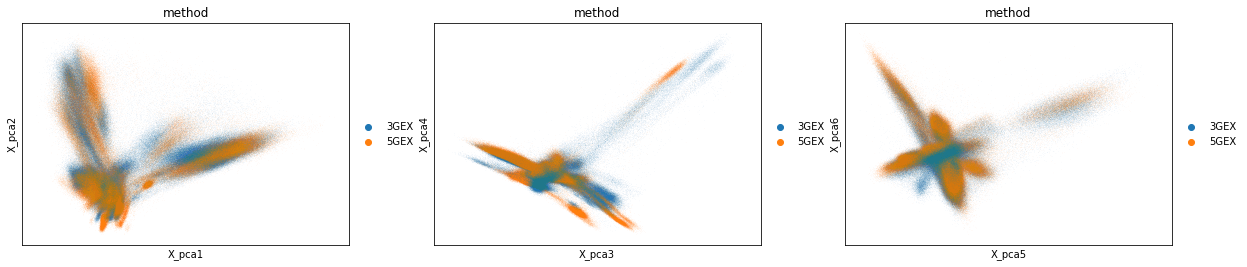

In [34]:
## Check results
sc.pl.embedding(merged_pp, "X_pca", color="method", components=["1,2", '3,4', '5,6'])
sc.pl.embedding(ndata, "X_pca", color="method", components=["1,2", '3,4', '5,6'])
# sc.pl.embedding(merged_pp, "X_pca_old", color="method", components=["1,2", '3,4', '5,6'])

In [43]:
merged_pp.obsm["X_pca_corrected"] = ndata.obsm["X_pca"]

In [45]:
merged_pp.obsm["X_pca"] = merged_pp.obsm["X_pca_corrected"]

In [46]:
today = datetime.now().date().strftime('%Y%m%d')
merged_pp.write_h5ad('/nfs/team205/ed6/data/Fetal_immune/PAN.A01.v01.entire_data_normalised_log.wGut.batchCorrected_{}.h5ad'.format(today))

In [47]:
merged_pp

AnnData object with n_obs × n_vars = 913795 × 3195
    obs: 'uniform_label', 'Sample', 'n_counts', 'n_genes', 'donor', 'organ', 'sort', 'method', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'name', 'batch', 'bbk', 'in_sketch', 'in_sketch_nn'
    var: 'GeneName', 'GeneID', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'method_colors', 'neighbors', 'organ_colors', 'pca', 'umap', 'uniform_label_colors'
    obsm: 'X_pca', 'X_pca_old', 'X_umap', 'X_pca_corrected'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

### Integration with BBKNN

In [48]:
## Full dataset
start=datetime.now()
bbknn(merged_pp, batch_key = "bbk", n_pcs=30, approx=True)
bbknn_time = datetime.now()-start
print("BBKNN runtime: ", str(bbknn_time))

start=datetime.now()
sc.tl.umap(merged_pp)
umap_time = datetime.now()-start
print("UMAP runtime: ", str(umap_time))

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/bbknn/__init__.py:289: FutureWarning: This location for 'distances' is deprecated. It has been moved to .obsp[distances], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['distances'] = bbknn_out[0]
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/bbknn/__init__.py:290: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'] = bbknn_out[1]


BBKNN runtime:  0:15:22.474364
UMAP runtime:  0:45:44.819092


In [81]:
merged_pp

AnnData object with n_obs × n_vars = 913795 × 3195
    obs: 'uniform_label', 'Sample', 'n_counts', 'n_genes', 'donor', 'organ', 'sort', 'method', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'name', 'batch', 'bbk'
    var: 'GeneName', 'GeneID', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'pca', 'method_colors', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_pca_old', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [49]:
today = datetime.now().date().strftime('%Y%m%d')
merged_pp.write_h5ad('/nfs/team205/ed6/data/Fetal_immune/PAN.A01.v01.entire_data_normalised_log.wGut.batchCorrected_{}.h5ad'.format(today))

### Visualize results

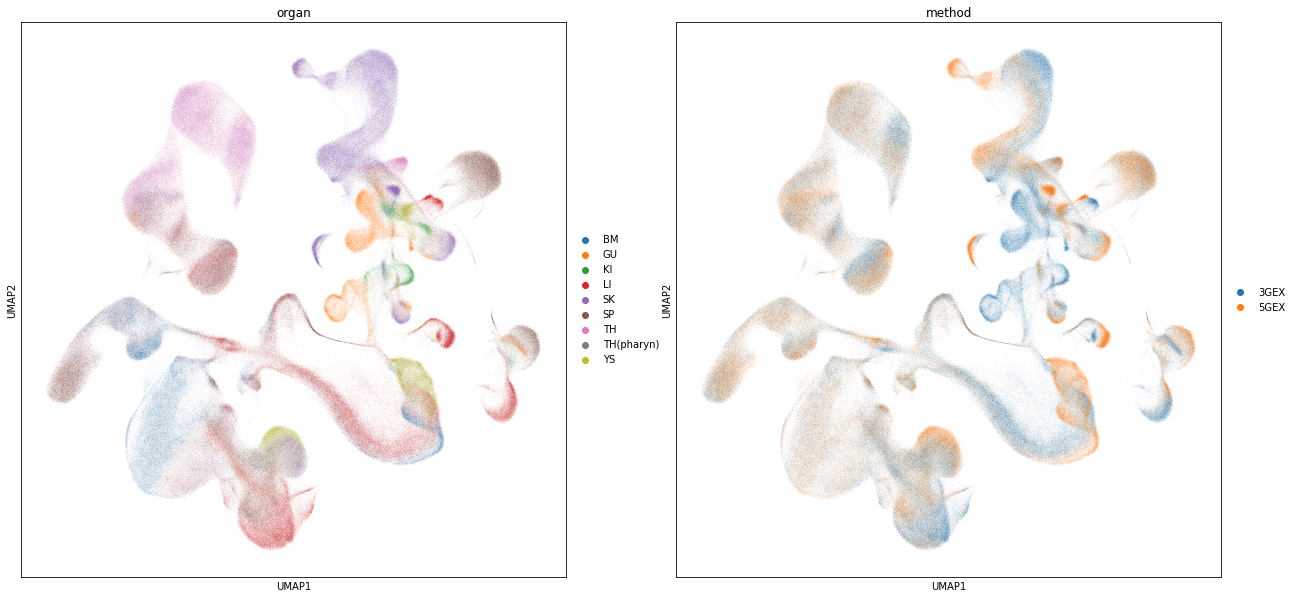

In [50]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [10,10]
sc.pl.umap(merged_pp, color=["organ", "method"])

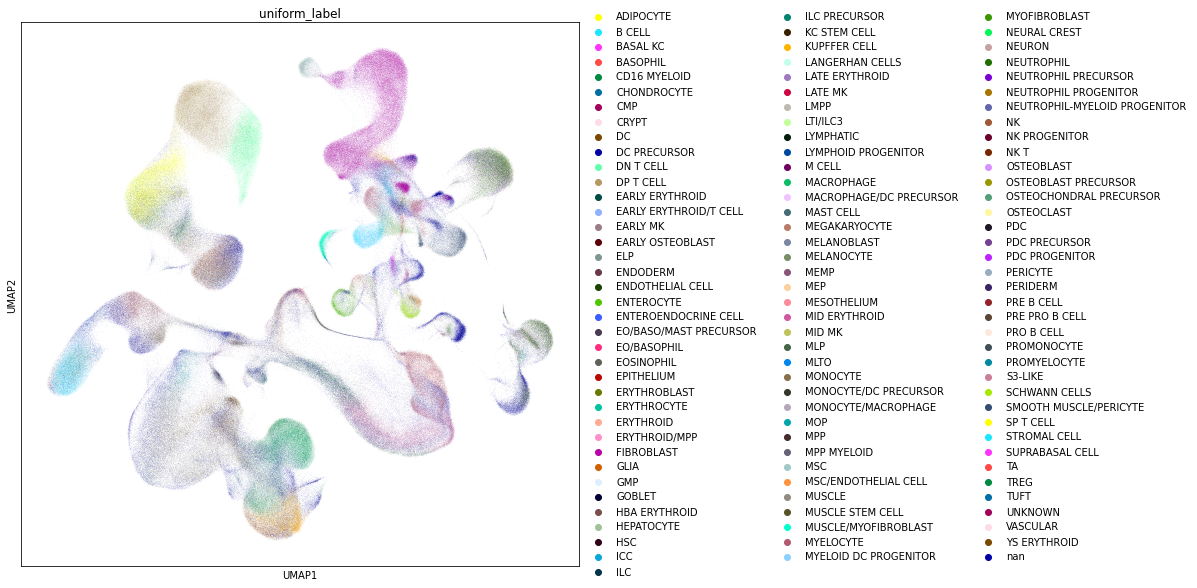

In [52]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [10,10]
sc.pl.umap(merged_pp, color=["uniform_label"])

Trying to set attribute `.uns` of view, copying.


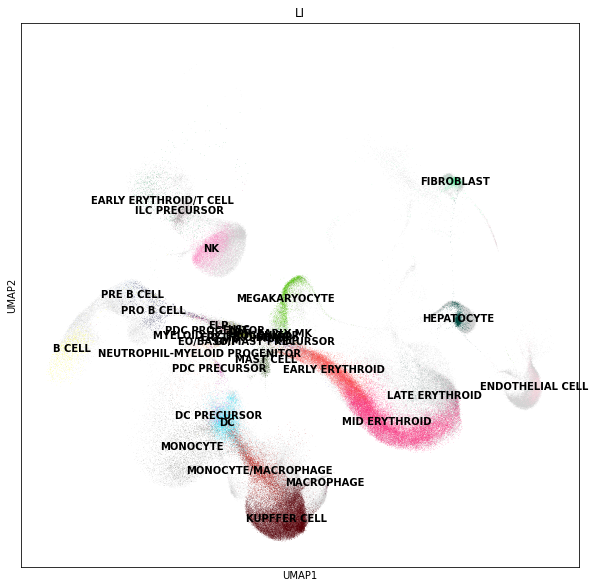

Trying to set attribute `.uns` of view, copying.


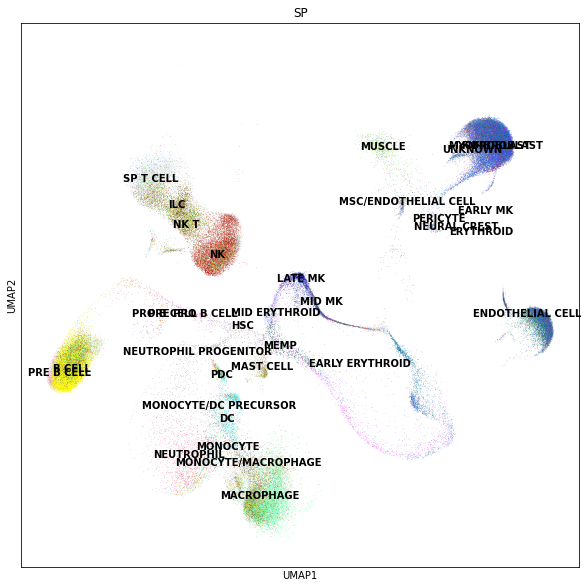

Trying to set attribute `.uns` of view, copying.


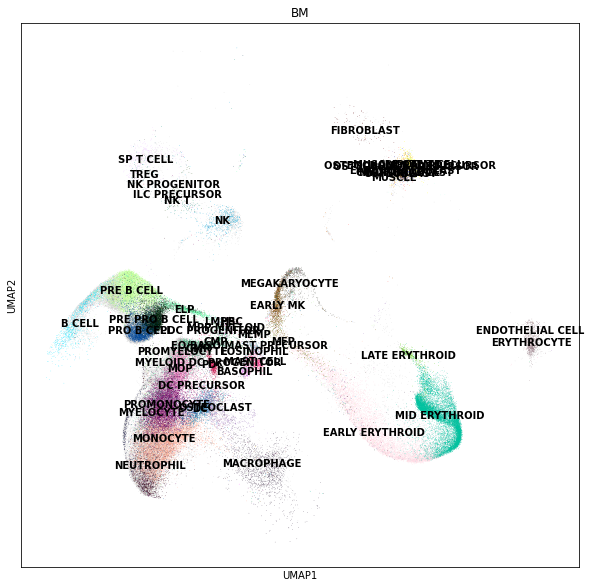

Trying to set attribute `.uns` of view, copying.


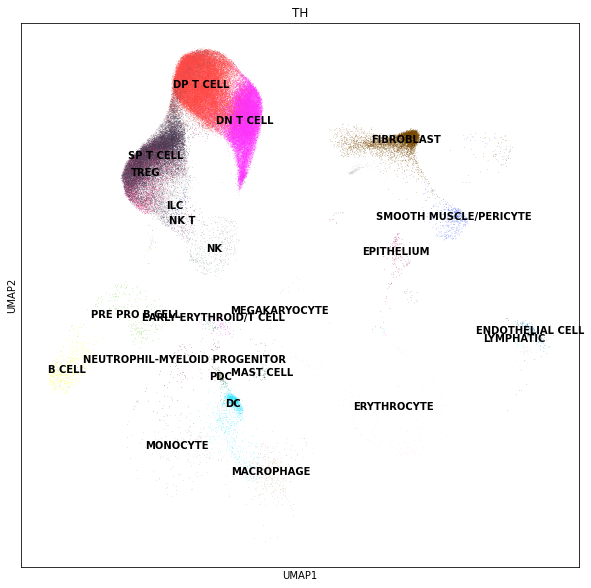

Trying to set attribute `.uns` of view, copying.


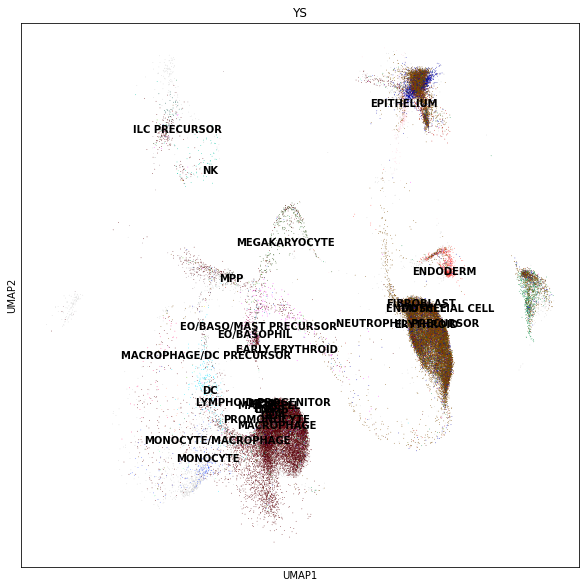

Trying to set attribute `.uns` of view, copying.


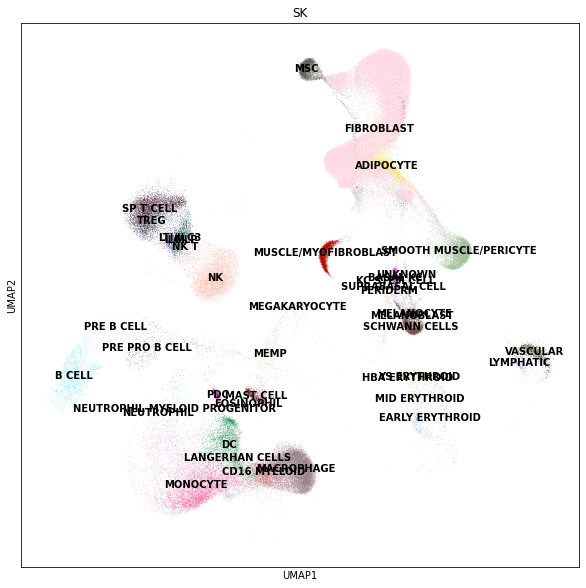

Trying to set attribute `.uns` of view, copying.


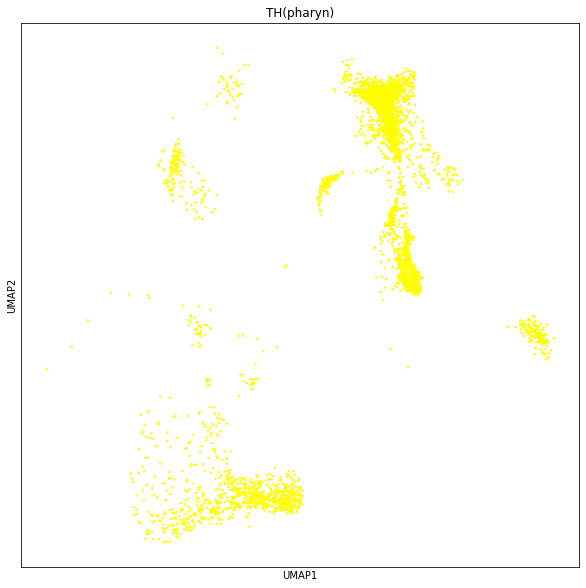

Trying to set attribute `.uns` of view, copying.


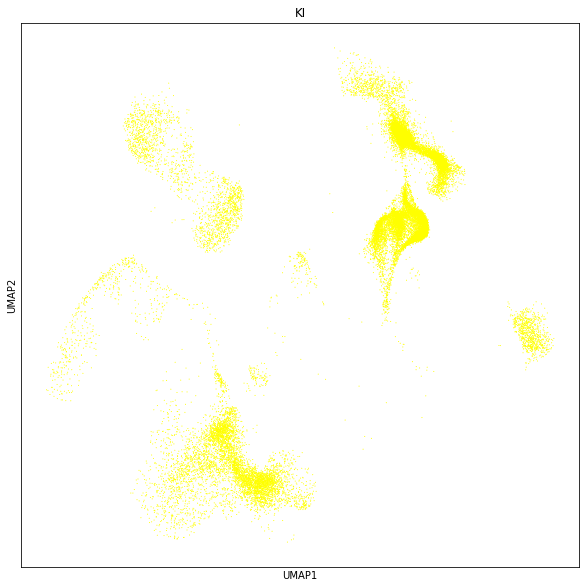

Trying to set attribute `.uns` of view, copying.


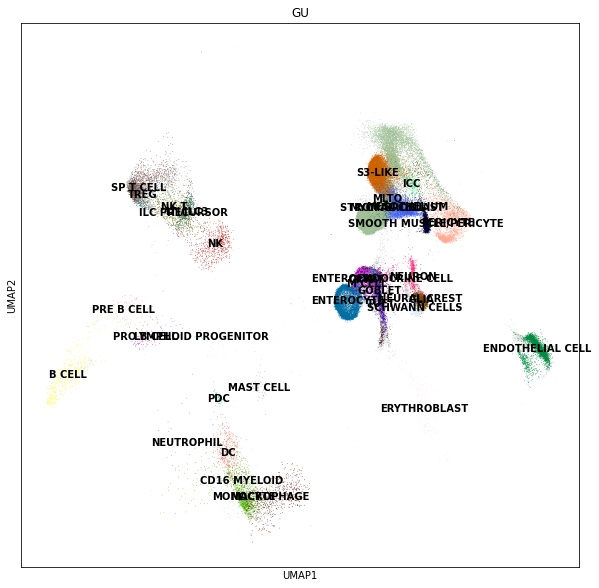

In [53]:
i=1
for org in merged_pp.obs['organ'].unique():
    subset_organ_adata = merged_pp[merged_pp.obs['organ']==org]
    sc.pl.umap(subset_organ_adata, color="uniform_label", palette=sc.plotting.palettes.default_102,
               legend_loc="on data",
               groups=subset_organ_adata[subset_organ_adata.obs["uniform_label"] != "nan"].obs["uniform_label"].unique(),
               title=org
              )
    i += 1

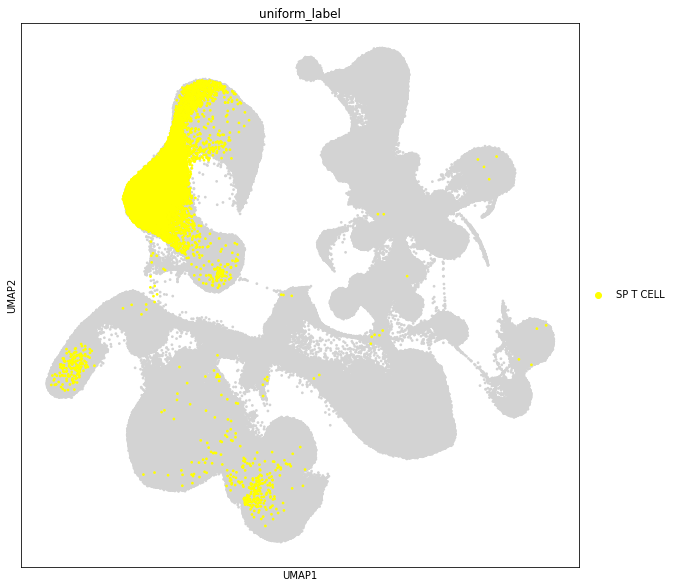

In [58]:
sc.pl.umap(merged_pp, color="uniform_label", palette=sc.plotting.palettes.default_102,               
               groups=[x for x in merged_pp.obs["uniform_label"].unique() if "SP T CELL" in x], size=30
              )

TypeError: info() missing 1 required positional argument: 'msg'

---